### 设置路径

In [1]:
path_pre = '../../'
path_modeling_dataset = path_pre + 'modeling-dataset/'
path_model = path_pre + 'model/'
path_original_dataset = path_pre + 'original-dataset/'
path_submission_dataset = path_pre + 'submission-dataset/'
path_intermediate_dataset = path_pre + 'intermediate-dataset/'

### 加载 test_ol

In [2]:
import pandas as pd

In [3]:
test_ol_df = pd.read_hdf(path_intermediate_dataset + 'test.h5')
test_ol_df.head()

,instanceID,label,clickTime,creativeID,userID,positionID,connectionType,telecomsOperator
0,1,-1,310000,3745,1164848,3451,1,3
1,2,-1,310000,2284,2127247,1613,1,3
2,3,-1,310000,1456,2769125,5510,2,1
3,4,-1,310000,4565,9762,4113,2,3
4,5,-1,310000,49,2513636,3615,1,3


In [4]:
ad_df = pd.read_hdf(path_intermediate_dataset + 'ad.h5')
# 合并表格
test_ol_df = test_ol_df.merge(ad_df[['creativeID', 'appID']], how='left', on='creativeID')
# 构造 'userID-appID' 列
test_ol_df['userID-appID'] = test_ol_df['userID'].astype(str) + '-' + test_ol_df['appID'].astype(str)
# 加载已经有安装行为的 'userID-appID'
userID_appID_test = pd.read_hdf(path_intermediate_dataset + 'userID_appID_for_test.h5')

In [5]:
test_ol_df.head()

,instanceID,label,clickTime,creativeID,userID,positionID,connectionType,telecomsOperator,appID,userID-appID
0,1,-1,310000,3745,1164848,3451,1,3,14,1164848-14
1,2,-1,310000,2284,2127247,1613,1,3,14,2127247-14
2,3,-1,310000,1456,2769125,5510,2,1,465,2769125-465
3,4,-1,310000,4565,9762,4113,2,3,465,9762-465
4,5,-1,310000,49,2513636,3615,1,3,14,2513636-14


### 加载 X_test_ol 和 model

In [6]:
from scipy.sparse import load_npz
from sklearn.externals import joblib

In [7]:
X_test_ol = load_npz(path_modeling_dataset + 'X_test_ol.npz')

In [8]:
clf = joblib.load(path_model + 'sgd_lr.pkl')

### 预测

In [9]:
y_test_ol = clf.predict_proba(X_test_ol)

### 构造 submission

In [10]:
submission = test_ol_df[['instanceID', 'label', 'userID-appID']].copy()
submission.rename(columns={'label': 'prob'}, inplace=True)
submission['prob'] = y_test_ol[:, 1]
submission.set_index('instanceID', inplace=True)
submission.sort_index(inplace=True)
submission.head()

,prob,userID-appID
instanceID,,
1,0.006640,1164848-14
2,0.005537,2127247-14
3,0.005072,2769125-465
4,0.004430,9762-465
5,0.005019,2513636-14


In [11]:
submission.tail()

,prob,userID-appID
instanceID,,
338485,0.006689,365374-465
338486,0.018235,2231643-391
338487,0.008074,1673380-328
338488,0.013095,1303085-465
338489,0.013226,490286-465


### 对于那些已经有安装行为的 'userID-appID', 应该都预测为0

In [13]:
import matplotlib.pyplot as plt

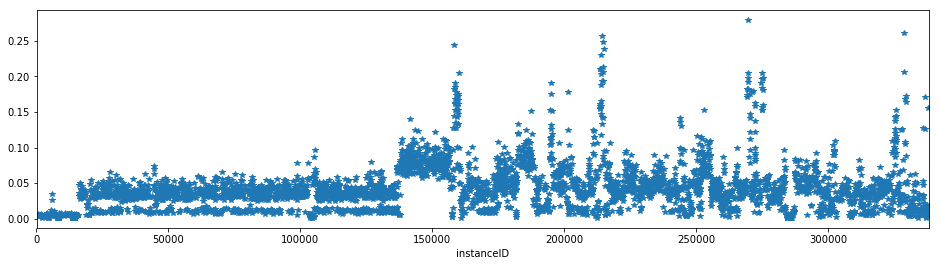

In [14]:
submission.loc[submission['userID-appID'].isin(userID_appID_test), 'prob'].plot(figsize=(16, 4), style='*')
plt.show()

In [14]:
submission.loc[submission['userID-appID'].isin(userID_appID_test), 'prob'] = 0
submission.head()

,prob,userID-appID
instanceID,,
1,0.006640,1164848-14
2,0.005537,2127247-14
3,0.005072,2769125-465
4,0.004430,9762-465
5,0.005019,2513636-14


### 输出

In [16]:
import zipfile 

In [17]:
# 删除 userID-appID 列
del submission['userID-appID']
submission.to_csv(path_submission_dataset + 'submission.csv')
zip = zipfile.ZipFile(path_submission_dataset + 'submission.zip', 'w') 
zip.write(path_submission_dataset + 'submission.csv', arcname='submission.csv', compress_type=zipfile.ZIP_DEFLATED) 
zip.close() 